## import packages, define variables

In [65]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd # for creation of data frames
import numpy as np #
import seaborn as sns
import nibabel as nib # for loading niftis etc. as arrays
import matplotlib.pyplot as plt # for plotting data
#the output of plotting commands is displayed inline, directly below the code cell that produced it
%matplotlib inline 
import os,glob
from nilearn import plotting, input_data, image #for plotting & working with niftis

import pathlib

###################### update path!! #####################################
base_path = '/root_dir/' ####
##########################################################################

#import qBOLD functions
#import sys
#sys.path.append(os.path.join(base_path + 'scripts/'))
#import mqBOLD_functions as qB


### define FSL directories ######################################################
os.environ["FSLDIR"]='/usr/share/fsl/5.0'
os.environ["FSLOUTPUTTYPE"]='NIFTI_GZ'
os.environ["FSLTCLSH"]='/usr/bin/tclsh'
os.environ["FSLWISH"]='/usr/bin/wish'
os.environ["FSLMULTIFILEQUIT"]="True"
os.environ["LD_LIBRARY_PATH"]='/usr/share/fsl/5.0:/usr/lib/fsl/5.0'
#################################################################################

In [66]:
data_dir = base_path + 'data/'
derivatives_dir = data_dir + 'derivatives'
raw_dir = data_dir + 'rawdata'
results_dir = base_path + 'results'

sns.set_style("whitegrid")
MNI_2mm_brain = derivatives_dir + '/MNI152_T1_2mm_brain.nii.gz'

## N=40
sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68]
## N=30
sids_30 = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55]

df_participants = pd.read_csv(data_dir + '/participants.tsv',sep='\t')

coords=(-15, 0, 15, 30, 45, 60, 75, 90)

### create csv table with values

In [100]:
## 1st level GLM masks: output from fmriprep
import shutil

## define z-threshold for ROI
z_thr=2.5

parameters=['cbf','cmro2','oef', 'func']
#parameters=['func']

df_ROI_fMRI_median_values = pd.DataFrame(columns=['ID', 'par', 'ROI', 'cond', 'median', 'mean', 'std'])
df_ROI_qBOLD_median_values = pd.DataFrame(columns=['ID', 'par', 'ROI', 'cond', 'median', 'mean', 'std', 'num_vox'])

for i, ID in enumerate(sids): #loop over subjects

    sub = "sub-p{:03d}".format(ID) 
    print(sub)
    dir_work = os.path.join(data_dir, sub)
    
    dir_anat = os.path.join(dir_work, 'anat')
    dir_func = os.path.join(dir_work, 'func')
    dir_perf = os.path.join(dir_work, 'perf')
    
    dir_deriv = os.path.join(data_dir, 'derivatives', sub)
    dir_anat_deriv = os.path.join(data_dir, 'derivatives', sub, 'anat')
    dir_func_deriv = os.path.join(data_dir, 'derivatives', sub, 'func')
    dir_perf_deriv = os.path.join(data_dir, 'derivatives', sub, 'perf')
    dir_qmri_deriv = os.path.join(data_dir, 'derivatives', sub, 'qmri')
 
    for par in parameters:
                         
        if par == 'func':# output from fmriprep, registered to T2 space
            par_map =  os.path.join(dir_func_deriv, sub+ '_task-all_space-T2_desc-preproc_bold.nii.gz')
            par_map_img = nib.load(par_map)
            par_map_arr = np.array(par_map_img.dataobj) 
            if ID<56:
                ROIs = ['calccontrol', 'controlcalc', 'calcrest','restcalc', 'memcontrol', 'controlmem'] #visuomotor: control>rest
            if ID>55:
                ROIs = ['calccontrol', 'controlcalc']

            #mask with 1st level masks
            for ROI in ROIs: #loop over ROIs of interest
                ROI_nii = os.path.join(dir_func_deriv, sub + '_1stlevel_'+ROI+'_space-T2_qBmasked.nii.gz')
                ROI_nii_zthr = os.path.join(dir_func_deriv, sub + '_1stlevel_'+ROI+'_space-T2_zthr_qBmasked.nii.gz')
                ! fslmaths {ROI_nii} -thr {z_thr} {ROI_nii_zthr} 
                ROI_arr = np.array(nib.load(ROI_nii_zthr).dataobj)    
                par_masked = par_map_arr[ROI_arr>0.0001]
                par_median = np.nanmedian(par_masked, axis=0) #median across voxels per ROI
                if ID<56:
                    baseline_control = np.median(par_median[list(range(80, 100)) + list(range(205, 225)) + list(range(280, 300)) + list(range(355, 375))])  
                    baseline_rest = np.median(par_median[list(range(5, 25)) + list(range(130, 150)) + list(range(230, 250)) + list(range(330, 350))])
                    calc = par_median[list(range(55, 75)) + list(range(155, 175)) + list(range(255, 275)) + list(range(305, 325))]
                    mem = par_median[list(range(30, 50)) + list(range(105, 125)) + list(range(180, 200)) + list(range(380, 400))] 

                    perc_calc_control = 100* (calc - baseline_control) / baseline_control
                    par_median = np.nanmedian(perc_calc_control, axis=0)
                    par_mean = np.nanmean(perc_calc_control, axis=0)
                    par_std = np.nanstd(perc_calc_control, axis=0) 
                    new_row = {'ID':ID, 'par':par, 'ROI': ROI, 'cond':'calccontrol', 'median':par_median, 'mean':par_mean, 'std':par_std}
                    df_ROI_fMRI_median_values = df_ROI_fMRI_median_values.append(new_row, ignore_index = True)  

                    perc_mem_control = 100* (mem - baseline_control) / baseline_control
                    par_median = np.nanmedian(perc_mem_control, axis=0)
                    par_mean = np.nanmean(perc_mem_control, axis=0)
                    par_std = np.nanstd(perc_mem_control, axis=0) 
                    new_row = {'ID':ID, 'par':par, 'ROI': ROI, 'cond':'memcontrol', 'median':par_median, 'mean':par_mean, 'std':par_std}
                    df_ROI_fMRI_median_values = df_ROI_fMRI_median_values.append(new_row, ignore_index = True)  

                    perc_calc_rest = 100* (calc - baseline_rest) / baseline_rest
                    par_median = np.nanmedian(perc_calc_rest, axis=0)
                    par_mean = np.nanmean(perc_calc_rest, axis=0)
                    par_std = np.nanstd(perc_calc_rest, axis=0) 
                    new_row = {'ID':ID, 'par':par, 'ROI': ROI, 'cond':'calcrest', 'median':par_median, 'mean':par_mean, 'std':par_std}
                    df_ROI_fMRI_median_values = df_ROI_fMRI_median_values.append(new_row, ignore_index = True)  

                    perc_mem_rest = 100* (mem - baseline_rest) / baseline_rest
                    par_median = np.nanmedian(perc_mem_rest, axis=0)
                    par_mean = np.nanmean(perc_mem_rest, axis=0)
                    par_std = np.nanstd(perc_mem_rest, axis=0 )           
                    new_row = {'ID':ID, 'par':par, 'ROI': ROI, 'cond':'memrest', 'median':par_median, 'mean':par_mean, 'std':par_std}
                    df_ROI_fMRI_median_values = df_ROI_fMRI_median_values.append(new_row, ignore_index = True)  

                if ID>55:
                    baseline_control = np.median(par_median[list(range(5, 25)) + list(range(55, 75)) + list(range(105, 125)) + list(range(155, 175))])  
                    calc = par_median[list(range(30, 50)) + list(range(80, 100)) + list(range(130, 150)) + list(range(180, 200))]

                    perc_calc_control = 100* (calc - baseline_control) / baseline_control
                    par_median = np.nanmedian(perc_calc_control, axis=0)
                    par_mean = np.nanmean(perc_calc_control, axis=0)
                    par_std = np.nanstd(perc_calc_control, axis=0) 
                    new_row = {'ID':ID, 'par':par, 'ROI': ROI, 'cond':'calccontrol', 'median':par_median, 'mean':par_mean, 'std':par_std}
                    df_ROI_fMRI_median_values = df_ROI_fMRI_median_values.append(new_row, ignore_index = True)  

            ## save as csv after each subject
            df_ROI_fMRI_median_values.to_csv(os.path.join(results_dir, '1stlevel_ROIs_masked_fMRI.csv'))


        if par != 'func':#filtered func, output from fmriprep, registered to T2 space
            if ID<56:
                conds = ['rest', 'control', 'mem', 'calc']
                ROIs = ['calccontrol', 'controlcalc', 'calcrest','restcalc', 'memcontrol', 'controlmem'] #visuomotor: control>rest
            if ID>55:
                conds = ['control','calc']
                ROIs = ['calccontrol', 'controlcalc']

                
            for cond in conds: 
                if par != 'cmro2':
                    par_map =  os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_'+ par +'.nii')
                if par == 'cmro2'  and cond == 'calc':
                    if os.path.isfile(os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_desc-CBV_'+ par +'.nii.gz')):
                        par_map =  os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_desc-CBV_'+ par +'.nii.gz')
                    if os.path.isfile(os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_desc-CBV_'+ par +'.nii')):
                        par_map =  os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_desc-CBV_'+ par +'.nii')
                        
                if par == 'cmro2' and cond != 'calc':
                    if os.path.isfile(os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_desc-orig_'+ par +'.nii.gz')):
                        par_map =  os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_desc-orig_'+ par +'.nii.gz')
                    if os.path.isfile(os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_desc-orig_'+ par +'.nii')):
                        par_map =  os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_desc-orig_'+ par +'.nii')

                par_map_img = nib.load(par_map)
                par_map_arr = np.array(par_map_img.dataobj)

                ## if CBF, values have to be upscaled by 25% because of background supression pulses!
                if par == 'cbf': 
                    par_map_arr = par_map_arr / 0.75 

                #mask with 1st level masks
                for ROI in ROIs: #loop over ROIs of interest
                    ROI_nii = os.path.join(dir_func_deriv, sub + '_1stlevel_'+ROI+'_space-T2_qBmasked.nii.gz')
                    ROI_nii_zthr = os.path.join(dir_func_deriv, sub + '_1stlevel_'+ROI+'_space-T2_zthr_qBmasked.nii.gz')
                    ! fslmaths {ROI_nii} -thr {z_thr} {ROI_nii_zthr} 
                    ROI_arr = np.array(nib.load(ROI_nii_zthr).dataobj)    
                    par_masked = par_map_arr[ROI_arr>0.0001]
                    par_median = np.nanmedian(par_masked)
                    par_mean = np.nanmean(par_masked)
                    par_std = np.nanstd(par_masked)
                    par_num_vox = len(par_masked)

                    #store values in dataframe
                    new_row = {'ID':ID, 'par':par, 'ROI': ROI, 'cond':cond, 'median':par_median, 'mean':par_mean, 'std':par_std, 'num_vox':par_num_vox}
                    df_ROI_qBOLD_median_values = df_ROI_qBOLD_median_values.append(new_row, ignore_index = True)

                ## save as csv after each subject
                df_ROI_qBOLD_median_values.to_csv(os.path.join(results_dir, '1stlevel_ROIs_masked_qBOLD.csv'))

sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p058
sub-p059
sub-p060
sub-p061
sub-p063
sub-p064
sub-p065
sub-p066
sub-p067
sub-p068


### plot boxplots

In [118]:
## Please specify task & baseline ##
####################################

## define which conditions to plot
################################################################################################
baseline = 'rest'
#baseline = 'control'

task = 'calc'
#task = 'mem'
################################################################################################


labels=[baseline, task]

contrast = task + baseline #for fMRI %change values
ROIs =[task + baseline, baseline + task] ## GLM ROIs 
conds = [baseline, task]

## Please specify subject list##
################################

if baseline == 'control' and task == 'calc':
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68]
else: #N=30
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55]


N_subj = str(len(sids))
GM_thresh = 0.5

In [119]:
fontsize = 25
sns.set_style("whitegrid")
##define your colour palette

my_colors_act = [ 'bisque', 'darkorange']
my_colors_deact = [ 'lightskyblue', 'dodgerblue']

## data are stored in store_ROI_atlas_data_csv.ipynb
## CBV-corrected values are used for OEF and CMRO2 calc!
df_ROI_qBOLD_median_values = pd.read_csv(os.path.join(results_dir, '1stlevel_ROIs_masked_qBOLD.csv'))
df_ROI_fMRI_median_values = pd.read_csv(os.path.join(results_dir, '1stlevel_ROIs_masked_fMRI.csv'))


### func BOLD data

calcrest BOLD % change = 1.0053839
calcrest BOLD % change = 1.0032970416666667 +/- 0.33528192083970526
calcrest BOLD % change = -0.377809215
calcrest BOLD % change = -0.3830234313333333 +/- 0.223528218720072


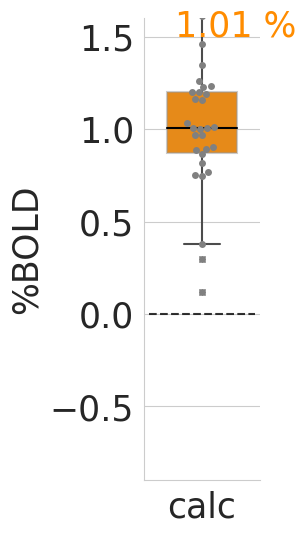

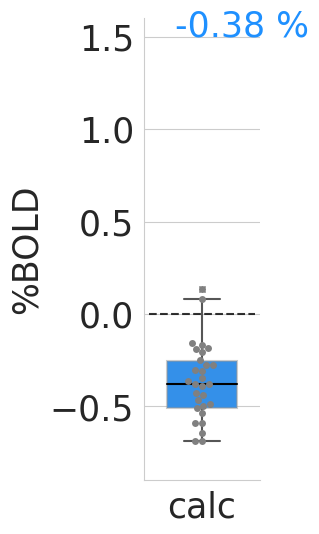

In [120]:
df_BOLD=pd.DataFrame()
for k, ROI in enumerate(ROIs):                   
    df_df_BOLD = pd.DataFrame()
    for i, ID in enumerate(sids): 
        BOLD = df_ROI_fMRI_median_values.query(f"par=='func' & ROI=='{ROI}' & cond=='{contrast}' & ID=={ID}")['median'].values                      
        new_row = {'ID':ID, 'median':BOLD[0]}
        df_df_BOLD = df_df_BOLD.append(new_row, ignore_index = True)                    

    df_BOLD[ROI] = df_df_BOLD['median']
    
    fig, ax = plt.subplots(1, 1, figsize=(1.5,6))
    
    if ROI == 'calccontrol' or ROI == 'calcrest' or ROI == 'memcontrol':
        colors = ['darkorange']
    if ROI == 'controlcalc'or ROI == 'restcalc' or ROI == 'controlmem':
        colors = ['dodgerblue']
        
    sns.boxplot(data = df_df_BOLD['median'],  orient='v', ax=ax,palette=colors, saturation=0.8,
                   boxprops={"edgecolor": (.6, .6, .6, .5)}, flierprops={"marker": "x"},
                   medianprops={"color": "black"})
    sns.swarmplot(data = df_df_BOLD['median'], orient='v', ax=ax, color='grey')
    plt.hlines(0, -0.6, 0.6, color='black', alpha=0.8, linestyles='dashed')
    ax.text(-0.3, 1.5, str(round(np.median(df_df_BOLD['median']), 2))+' %', color=colors[0], fontsize=fontsize)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
    ax.set_ylabel('%BOLD', fontsize=fontsize)
    ax.set_ylim(-0.9,1.6)
    #ax.set_title(ROI + ' region: ' + contrast)
    
    for pos in ['right', 'top']:
        ax.spines[pos].set_visible(False)

    ax.set_xticklabels([labels[1]])
    
    fig.show()
    print(contrast + ' BOLD % change = '+ str(np.median(df_df_BOLD['median'])) )
    print(contrast + ' BOLD % change = '+ str(np.mean(df_df_BOLD['median'])) + ' +/- ' +str(np.std(df_df_BOLD['median'])))
    
    fig.savefig(os.path.join(results_dir,  'N'+N_subj + '_1stlevel_ROI_func_' + ROI + '_boxplots.png'), dpi=300, bbox_inches='tight')


### CBF

CBF baseline = 45.32010474840161 +/- 8.827219462805402
CBF task = 49.617013283632176 +/- 9.263821722951107
delta CBF = 4.397919256545027 +/- 3.1970821214284073
t-value = 7.237712309079219
p-value = 5.7164748938792154e-08
CBF baseline = 47.70949448094458 +/- 7.845171015931492
CBF task = 46.356896742619305 +/- 7.193946942838666
delta CBF = -1.192327330584849 +/- 3.5648292972168
t-value = -2.0432848620061024
p-value = 0.050204216380308295


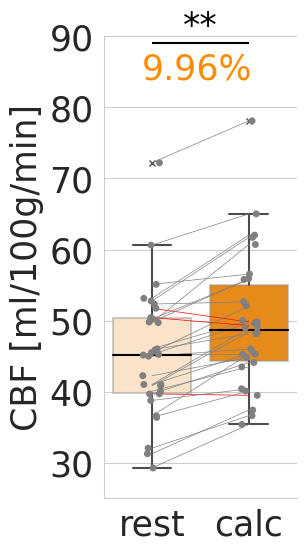

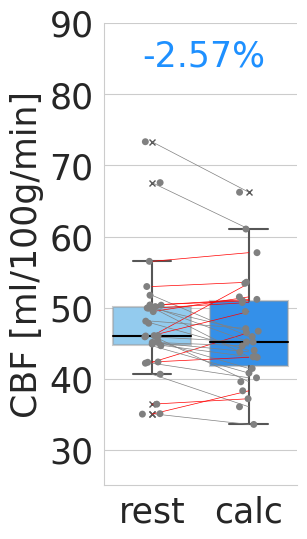

In [121]:
from scipy import stats

grey_palette=["grey", "grey", "grey"]

for k, ROI in enumerate(ROIs): ## for ROIs                  
    fig, ax = plt.subplots(1,figsize=(2.5,6))
    df_qBOLD = pd.DataFrame()
    ID_colour_code=[]
    for cond in conds:
        qBOLD=np.zeros(len(sids))
        qBOLD_diff=np.zeros(len(sids))
        for i, ID in enumerate(sids): 
            qBOLD[i] = df_ROI_qBOLD_median_values.query(f"par=='cbf' & ROI=='{ROI}' & cond=='{cond}' & ID=={ID}")['median'].values  
            qBOLD_diff[i] = df_ROI_qBOLD_median_values.query(f"par=='cbf' & ROI=='{ROI}' & cond=='{task}' & ID=={ID}")['median'].values - df_ROI_qBOLD_median_values.query(f"par=='cbf' & ROI=='{ROI}' & cond=='{baseline}' & ID=={ID}")['median'].values  
        if cond=='control' or cond=='rest': ##baseline
            df_qBOLD['baseline'] = qBOLD                 
        if cond=='calc' or cond=='mem': ##task
            df_qBOLD['task'] = qBOLD                 

    ## significance: paired t-tests
    [tvalue, pvalue] = stats.ttest_rel(df_qBOLD['task'], df_qBOLD['baseline'])
    
    ## print mean and std values
    CBF_baseline = df_ROI_qBOLD_median_values.query(f"par=='cbf' & ROI=='{ROI}' & cond=='{baseline}' & ID=={sids}")['median'].values
    CBF_task = df_ROI_qBOLD_median_values.query(f"par=='cbf' & ROI=='{ROI}' & cond=='{task}' & ID=={sids}")['median'].values
    print('CBF baseline = ' + str(np.mean(CBF_baseline)) + ' +/- ' + str(np.std(CBF_baseline)))
    print('CBF task = ' + str(np.mean(CBF_task)) + ' +/- ' + str(np.std(CBF_task)))
    print('delta CBF = ' + str(np.nanmedian(df_qBOLD['task']-df_qBOLD['baseline'])) + ' +/- ' + str(np.std(df_qBOLD['task']-df_qBOLD['baseline'])))
    print('t-value = ' + str(tvalue))
    print('p-value = ' + str(pvalue))
    
    
    ##%signal change
    df_qBOLD['percchange']  = (df_qBOLD['task'] - df_qBOLD['baseline']) / df_qBOLD['baseline'] * 100
    
    ## get colors for line, depending if percchange is negative or positive
    if ROI=='calccontrol' or ROI =='calcrest' or ROI == 'memcontrol': ## activation ROI
        df_CBF_percchange = df_qBOLD['percchange']
        colors=my_colors_act
        for s in range(0, len(sids)):
            if qBOLD_diff[s]>0:
                ID_colour_code.append('gray')
            if qBOLD_diff[s]<0:
                ID_colour_code.append('red')        
    if ROI=='controlcalc' or ROI == 'restcalc' or ROI == 'controlmem': ##deactivation ROI
        colors=my_colors_deact
        for s in range(0, len(sids)):
            if qBOLD_diff[s]<0:
                ID_colour_code.append('gray')
            if qBOLD_diff[s]>0:
                ID_colour_code.append('red') 
                
    sns.boxplot(data = df_qBOLD,  orient='v', ax=ax,palette=colors, saturation=0.8,
                   boxprops={"edgecolor": (.6, .6, .6, .5)}, flierprops={"marker": "x"},
                   medianprops={"color": "black"})
    #sns.swarmplot(data = df_qBOLD, orient='v', ax=ax, color='grey')
    sns.stripplot(data = df_qBOLD, orient='v', ax=ax, palette=grey_palette)
    for line, ID in enumerate(sids): # for each subject separately
        ax.plot((df_ROI_qBOLD_median_values.query(f"par=='cbf' & ROI=='{ROI}' & cond=='{baseline}' & ID=={ID}")['median'].values, 
                   df_ROI_qBOLD_median_values.query(f"par=='cbf' & ROI=='{ROI}' & cond=='{task}' & ID=={ID}")['median'].values),   
                  linewidth=0.5, color=ID_colour_code[line]) #plot lines = subjects 

    ## plot significance
    #axis.plot([0, 0, 1, 1], [83, 84, 84, 83], lw=1.5, c='black')
    
    if pvalue<0.001:
        ax.text(0.5, 89, "**", ha='center', va='bottom', color='black', fontsize=fontsize)
        ax.hlines(89, 0, 1, color='black')
    if pvalue<0.05 and pvalue>0.001:
        ax.text(0.5, 89, "*", ha='center', va='bottom', color='black', fontsize=fontsize)
        ax.hlines(89, 0, 1, color='black')
        
    ax.text(-0.1, 84, str(round(np.median(df_qBOLD['percchange']), 2))+'%', color=colors[1], fontsize=fontsize, alpha=1)
    ax.set_ylim(25, 90)
    ax.set_ylabel('CBF [ml/100g/min]', fontsize=fontsize)
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks((0,1), labels=labels)

    for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)
            
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
            
    fig.show()
    
    fig.savefig(os.path.join(results_dir, 'N'+N_subj + '_1stlevel_ROI_cbf_'+ ROI + '_boxplots.png'), dpi=300, bbox_inches='tight')


### CMRO2

CMRO2 baseline = 123.52300044020777 +/- 24.460335587821795
CMRO2_task task = 131.81961893828105 +/- 23.060922378928776
delta CMRO2 = 6.521916778178181 +/- 8.075982340554917
t-value = 5.532287723028311
p-value = 5.785541724057383e-06
CMRO2 baseline = 123.66125373838896 +/- 20.328267622694735
CMRO2_task task = 121.46593357715462 +/- 18.82673419155724
delta CMRO2 = -0.9525929509184436 +/- 8.348992630431106
t-value = -1.4159984798144207
p-value = 0.1674275165555673


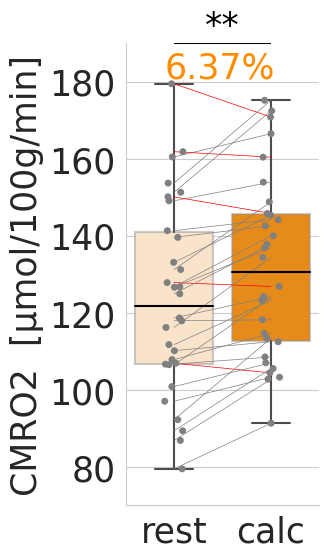

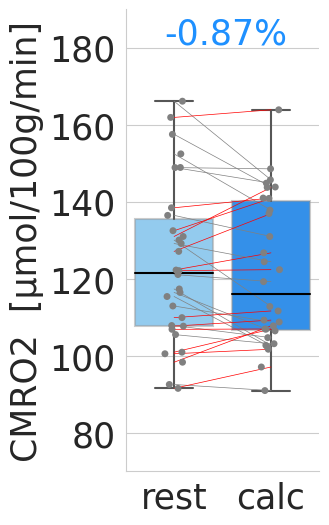

In [122]:
grey_palette=["grey", "grey", "grey"]

for k, ROI in enumerate(ROIs): ## for ROIs                  
    fig, ax= plt.subplots(1, figsize=(2.5,6))
    df_qBOLD= pd.DataFrame()
    ID_colour_code=[]
    for cond in conds:
        qBOLD=np.zeros(len(sids))
        qBOLD_diff=np.zeros(len(sids))
        for i, ID in enumerate(sids): 
            qBOLD[i] = df_ROI_qBOLD_median_values.query(f"par=='cmro2' & ROI=='{ROI}' & cond=='{cond}' & ID=={ID}")['median'].values  
            qBOLD_diff[i] = df_ROI_qBOLD_median_values.query(f"par=='cmro2' & ROI=='{ROI}' & cond=='{task}' & ID=={ID}")['median'].values - df_ROI_qBOLD_median_values.query(f"par=='cmro2' & ROI=='{ROI}' & cond=='{baseline}' & ID=={ID}")['median'].values  
        if cond=='control' or cond=='rest': ##baseline
            df_qBOLD['baseline'] = qBOLD                 
        if cond=='calc' or cond=='mem': ##task
            df_qBOLD['task'] = qBOLD                 

     
    ## significance: paired t-tests
    [tvalue, pvalue] = stats.ttest_rel(df_qBOLD['task'], df_qBOLD['baseline'])
    
    ## print mean and std values
    CMRO2_baseline = df_ROI_qBOLD_median_values.query(f"par=='cmro2' & ROI=='{ROI}' & cond=='{baseline}' & ID=={sids}")['median'].values
    CMRO2_task = df_ROI_qBOLD_median_values.query(f"par=='cmro2' & ROI=='{ROI}' & cond=='{task}' & ID=={sids}")['median'].values
    print('CMRO2 baseline = ' + str(np.mean(CMRO2_baseline)) + ' +/- ' + str(np.std(CMRO2_baseline)))
    print('CMRO2_task task = ' + str(np.mean(CMRO2_task)) + ' +/- ' + str(np.std(CMRO2_task)))
    print('delta CMRO2 = ' + str(np.nanmedian(df_qBOLD['task']-df_qBOLD['baseline'])) + ' +/- ' + str(np.std(df_qBOLD['task']-df_qBOLD['baseline'])))
    print('t-value = ' + str(tvalue))
    print('p-value = ' + str(pvalue))
    
    ##%signal change
    df_qBOLD['percchange']  = (df_qBOLD['task'] - df_qBOLD['baseline']) / df_qBOLD['baseline'] * 100 
    
    if ROI=='calccontrol' or ROI =='calcrest' or ROI == 'memcontrol': ## activation ROI
        colors=my_colors_act
        for s in range(0, len(sids)):
            if qBOLD_diff[s]>0:
                ID_colour_code.append('gray')
            if qBOLD_diff[s]<0:
                ID_colour_code.append('red')        
    if ROI=='controlcalc' or ROI == 'restcalc' or ROI == 'controlmem': ##deactivation ROI
        colors=my_colors_deact
        for s in range(0, len(sids)):
            if qBOLD_diff[s]<0:
                ID_colour_code.append('gray')
            if qBOLD_diff[s]>0:
                ID_colour_code.append('red') 
                
    sns.boxplot(data = df_qBOLD,  orient='v', ax=ax,palette=colors,saturation=0.8,
                   boxprops={"edgecolor": (.6, .6, .6, .5)}, flierprops={"marker": "x"},
                   medianprops={"color": "black"})
    sns.stripplot(data = df_qBOLD, orient='v', ax=ax, palette=grey_palette)
    for line, ID in enumerate(sids): # for each subject separately
        ax.plot((df_ROI_qBOLD_median_values.query(f"par=='cmro2' & ROI=='{ROI}' & cond=='{baseline}' & ID=={ID}")['median'].values, 
                   df_ROI_qBOLD_median_values.query(f"par=='cmro2' & ROI=='{ROI}' & cond=='{task}' & ID=={ID}")['median'].values),   
                  linewidth=0.5, color=ID_colour_code[line]) #plot lines = subjects 

    ## plot significance
    #axis.plot([0, 0, 1, 1], [200, 202, 202, 200], lw=1.5, c='black')
    if pvalue<0.001:
        ax.text(0.5, 190, "**", ha='center', va='bottom', color='black', fontsize=fontsize)
        ax.hlines(190, 0, 1, color='black')
    if pvalue<0.05 and pvalue>0.001:
        ax.text(0.5, 190, "*", ha='center', va='bottom', color='black', fontsize=fontsize)
        ax.hlines(190, 0, 1, color='black')
        
    ax.text(-0.1, 181, str(round(np.median(df_qBOLD['percchange']), 2))+'%', color=colors[1], fontsize=fontsize, alpha=1)
    ax.set_ylim(70, 190)
    ax.set_ylabel('CMRO2  [µmol/100g/min]', fontsize=fontsize)
    ax.set_xlim(-0.5, 1.5)

    for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)
            
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
    ax.set_xticks((0,1), labels=labels)
                                
    fig.show()
    
    fig.savefig(os.path.join(results_dir, 'N'+N_subj + '_1stlevel_ROI_cmro2_'+ ROI + '_boxplots.png'), dpi=300, bbox_inches='tight')



## OEF

OEF baseline = 0.3820636698271364 +/- 0.05723403211328256
OEF_task task = 0.3679516197328739 +/- 0.055897061606346346
delta OEF = -0.013871587927921147 +/- 0.013595950612562883
t-value = -5.589584552765324
p-value = 4.936858451242851e-06
OEF baseline = 0.3563281430357784 +/- 0.056833587129693365
OEF_task task = 0.35734399670815176 +/- 0.05209070411651738
delta OEF = 0.003606507071836601 +/- 0.016012727375631402
t-value = 0.34163695648674824
p-value = 0.7350874040540591


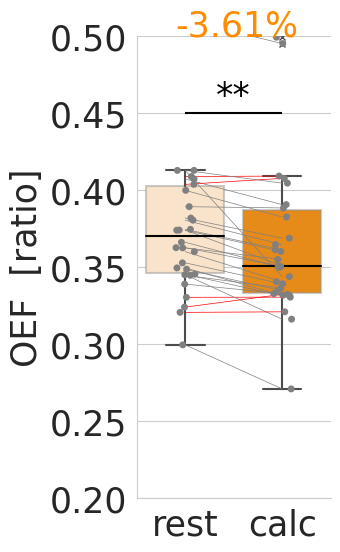

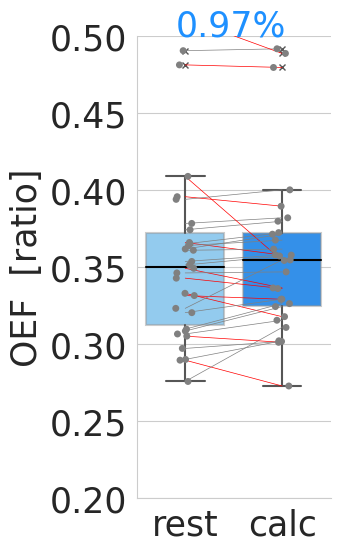

In [123]:
grey_palette=["grey", "grey", "grey"]

for k, ROI in enumerate(ROIs): ## for ROIs                  
    fig, ax= plt.subplots(1, figsize=(2.5,6))
    df_qBOLD= pd.DataFrame()
    ID_colour_code=[]
    for cond in conds:
        qBOLD=np.zeros(len(sids))
        qBOLD_diff=np.zeros(len(sids))
        for i, ID in enumerate(sids): 
            qBOLD[i] = df_ROI_qBOLD_median_values.query(f"par=='oef' & ROI=='{ROI}' & cond=='{cond}' & ID=={ID}")['median'].values  
            qBOLD_diff[i] = df_ROI_qBOLD_median_values.query(f"par=='oef' & ROI=='{ROI}' & cond=='{task}' & ID=={ID}")['median'].values - df_ROI_qBOLD_median_values.query(f"par=='oef' & ROI=='{ROI}' & cond=='{baseline}' & ID=={ID}")['median'].values  
        if cond=='control' or cond=='rest': ##baseline
            df_qBOLD['baseline'] = qBOLD                 
        if cond=='calc' or cond=='mem': ##task
            df_qBOLD['task'] = qBOLD                 

     
    ## significance: paired t-tests
    [tvalue, pvalue] = stats.ttest_rel(df_qBOLD['task'], df_qBOLD['baseline'])
    
    ## print mean and std values
    OEF_baseline = df_ROI_qBOLD_median_values.query(f"par=='oef' & ROI=='{ROI}' & cond=='{baseline}' & ID=={sids}")['median'].values
    OEF_task = df_ROI_qBOLD_median_values.query(f"par=='oef' & ROI=='{ROI}' & cond=='{task}' & ID=={sids}")['median'].values
    print('OEF baseline = ' + str(np.mean(OEF_baseline)) + ' +/- ' + str(np.std(OEF_baseline)))
    print('OEF_task task = ' + str(np.mean(OEF_task)) + ' +/- ' + str(np.std(OEF_task)))
    print('delta OEF = ' + str(np.nanmedian(df_qBOLD['task']-df_qBOLD['baseline'])) + ' +/- ' + str(np.std(df_qBOLD['task']-df_qBOLD['baseline'])))
    print('t-value = ' + str(tvalue))
    print('p-value = ' + str(pvalue))
    
    ##%signal change
    df_qBOLD['percchange']  = (df_qBOLD['task'] - df_qBOLD['baseline']) / df_qBOLD['baseline'] * 100 
    
    if ROI=='calccontrol' or ROI =='calcrest' or ROI == 'memcontrol': ## activation ROI
        colors=my_colors_act
        for s in range(0, len(sids)):
            if qBOLD_diff[s]<0:
                ID_colour_code.append('gray')
            if qBOLD_diff[s]>0:
                ID_colour_code.append('red')        
    if ROI=='controlcalc' or ROI == 'restcalc' or ROI == 'controlmem': ##deactivation ROI
        colors=my_colors_deact
        for s in range(0, len(sids)):
            if qBOLD_diff[s]>0:
                ID_colour_code.append('gray')
            if qBOLD_diff[s]<0:
                ID_colour_code.append('red') 
                
    sns.boxplot(data = df_qBOLD,  orient='v', ax=ax,palette=colors,saturation=0.8,
                   boxprops={"edgecolor": (.6, .6, .6, .5)}, flierprops={"marker": "x"},
                   medianprops={"color": "black"})
    sns.stripplot(data = df_qBOLD, orient='v', ax=ax, palette=grey_palette)
    for line, ID in enumerate(sids): # for each subject separately
        ax.plot((df_ROI_qBOLD_median_values.query(f"par=='oef' & ROI=='{ROI}' & cond=='{baseline}' & ID=={ID}")['median'].values, 
                   df_ROI_qBOLD_median_values.query(f"par=='oef' & ROI=='{ROI}' & cond=='{task}' & ID=={ID}")['median'].values),   
                  linewidth=0.5, color=ID_colour_code[line]) #plot lines = subjects 

    ## plot significance
    #axis.plot([0, 0, 1, 1], [200, 202, 202, 200], lw=1.5, c='black')
    if pvalue<0.001:
        ax.text(0.5, 0.45, "**", ha='center', va='bottom', color='black', fontsize=fontsize)
        ax.hlines(0.45, 0, 1, color='black')
    if pvalue<0.05 and pvalue>0.001:
        ax.text(0.45, 0.6, "*", ha='center', va='bottom', color='black', fontsize=fontsize)
        ax.hlines(0.45, 0, 1, color='black')
        
    ax.text(-0.1, 0.5, str(round(np.median(df_qBOLD['percchange']), 2))+'%', color=colors[1], fontsize=fontsize, alpha=1)
    ax.set_ylim(0.2, 0.5)
    ax.set_ylabel('OEF  [ratio]', fontsize=fontsize)
    ax.set_xlim(-0.5, 1.5)

    for pos in ['right', 'top']:
            ax.spines[pos].set_visible(False)
            
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)
    ax.set_xticks((0,1), labels=labels)
                                
    fig.show()
    
    fig.savefig(os.path.join(results_dir, 'N'+N_subj + '_1stlevel_ROI_oef_'+ ROI + '_boxplots.png'), dpi=300, bbox_inches='tight')

